In [1]:
%loadlibs
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from utils import rnmse
from torch.utils.data import TensorDataset, DataLoader

Loaded libraries:
	- numpy (np)
	- matplotlib.pyplot (plt)
	- torch
	- torch.nn (nn)
	- torch.optim (optim)
	- tqdm


In [2]:
x = torch.cat([torch.load("dataset/x_train.pt"), torch.load("dataset/x_train_2.pt")])
y = torch.cat([torch.load("dataset/y_train.pt"), torch.load("dataset/y_train_2.pt")])
c = torch.cat([torch.load("dataset/c_train.pt"), torch.load("dataset/c_train_2.pt")])

x_test = torch.load("dataset/x_test.pt")
y_test = torch.load("dataset/y_test.pt")
c_test = torch.load("dataset/c_test.pt")

In [3]:
x0, y0, c0 = x[0], y[0], c[0]

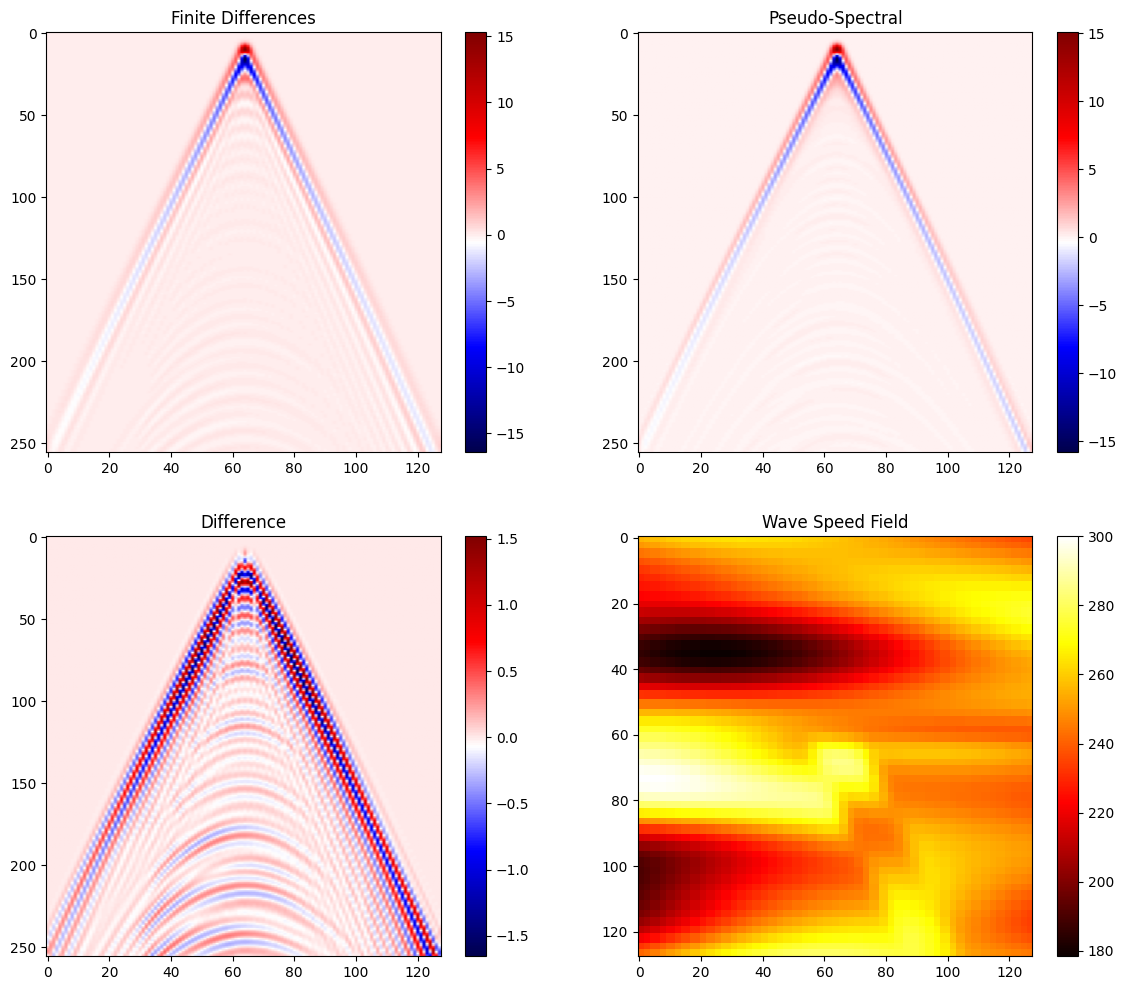

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
m = ax[0, 0].imshow(x0, aspect='auto', cmap='seismic')
ax[0, 0].set_title("Finite Differences")
plt.colorbar(m)
m = ax[0, 1].imshow(y0, aspect='auto', cmap='seismic')
ax[0, 1].set_title("Pseudo-Spectral")
plt.colorbar(m)
m = ax[1, 0].imshow((x0-y0), aspect='auto', cmap='seismic')
ax[1, 0].set_title("Difference")
plt.colorbar(m)
m = ax[1, 1].imshow(c0, aspect='auto', cmap='hot')
ax[1, 1].set_title("Wave Speed Field")
plt.colorbar(m)
plt.savefig("sample_example.jpg", dpi=150)
plt.show()

The initial error between FD and PS is evaluated.

In [5]:
print(f"Train RNSME: {rnmse(x, y)}")
print(f"Test RNSME: {rnmse(x_test, y_test)}")

Train RNSME: 0.38560399413108826
Test RNSME: 0.38336923718452454


First question: how well can the problem of getting $y$ (PS), knowing $x$ (FD) using a linear regression be solved ?

In [6]:
x_np, y_np, c_np = x.numpy(), y.numpy(), c.numpy()
x_np, y_np, c_np = x_np.reshape((x_np.shape[0], -1)), y_np.reshape((y_np.shape[0], -1)), c_np.reshape((c_np.shape[0], -1))
x_test_np, y_test_np, c_test_np = x_test.numpy(), y_test.numpy(), c_test.numpy()
x_test_np, y_test_np, c_test_np = x_test_np.reshape((x_test_np.shape[0], -1)), y_test_np.reshape((y_test_np.shape[0], -1)), c_test_np.reshape((c_test_np.shape[0], -1))

In [22]:
print(torch.mean(y-x))
print(torch.std(y-x))

tensor(5.1787e-07)
tensor(0.2418)


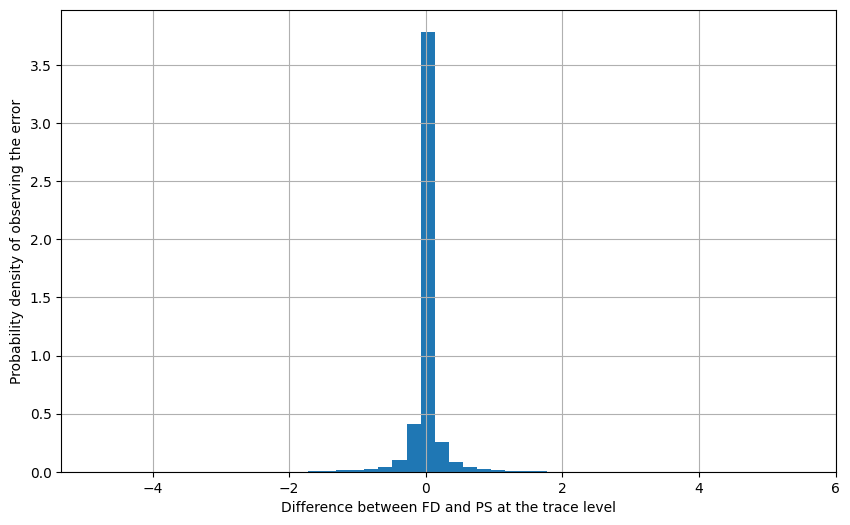

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(y_np[:1024].flatten()-x_np[:1024].flatten(), density=True, bins=50)
plt.grid()
plt.xlabel("Difference between FD and PS at the trace level")
plt.ylabel("Probability density of observing the error")
plt.savefig("error_analysis.jpg", dpi=150)
plt.show()

In [22]:
pca_errors = {}
for n_components in tqdm([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]):
    pca_x = PCA(n_components=n_components).fit(x_np)
    pca_y = PCA(n_components=n_components).fit(x_np)
    x_pca = pca_x.transform(x_np)
    y_pca = pca_y.transform(y_np)
    x_test_pca = pca_x.transform(x_test_np)
    y_test_pca = pca_y.transform(y_test_np)
    lm = LinearRegression().fit(x_pca, y_pca)
    y_test_hat = pca_y.inverse_transform(lm.predict(x_test_pca))
    pca_errors[n_components] = rnmse(y_test_np, y_test_hat)

  0%|          | 0/10 [00:00<?, ?it/s]

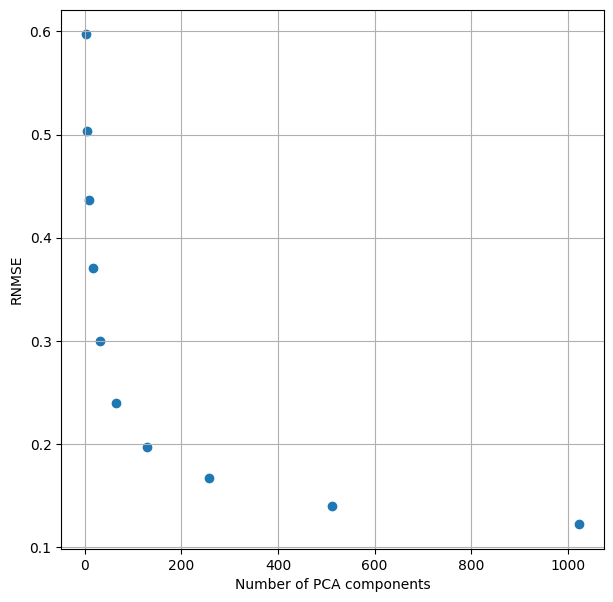

In [37]:
plt.figure(figsize=(7, 7))
plt.scatter(pca_errors.keys(), pca_errors.values())
plt.grid()
plt.xlabel("Number of PCA components")
plt.ylabel("RNMSE")
plt.savefig('pca_error.jpg', dpi=150)

Let's evaluate with some ensemble method.

In [11]:
from xgboost import XGBRegressor

In [12]:
xgb = XGBRegressor().fit(x_pca, y_pca)
y_test_hat = pca_y.inverse_transform(xgb.predict(x_test_pca))
rnmse(y_test_np, y_test_hat)

np.float32(0.21935615)

Now we try a MLP.

In [13]:
device = 'mps'
x_pca_torch = torch.from_numpy(x_pca).float()
y_pca_torch = torch.from_numpy(y_pca)
x_test_pca_torch  = torch.from_numpy(x_test_pca).float()
y_test_pca_torch  = torch.from_numpy(y_test_pca)

batch_size = 128
train_loader = DataLoader(TensorDataset(x_pca_torch, y_pca_torch),
                          batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(x_test_pca_torch, y_test_pca_torch),
                          batch_size=batch_size, shuffle=False)

In [14]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

In [15]:
output_dim = 1 if y_pca.ndim == 1 else y_pca.shape[1]

model = MLP(input_dim=x_pca.shape[1],
            output_dim=output_dim).to(device)

criterion = rnmse
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 50
for epoch in (pbar:=tqdm(range(epochs))):
    model.train()
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.float().to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        pbar.set_description(f"Loss: {loss.item():.5f}")
        optimizer.step()

  0%|          | 0/50 [00:00<?, ?it/s]

In [16]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.float().to(device)
        test_loss += criterion(model(xb), yb).item()
test_loss /= len(test_loader)
print(f"Test MSE: {test_loss:.6f}")

Test MSE: 0.108755


And we do the same without PCA.

In [17]:
class MLP2(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

In [18]:
batch_size = 128
train_loader = DataLoader(TensorDataset(torch.from_numpy(x_np).float(), torch.from_numpy(y_np).float()),
                          batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(TensorDataset(torch.from_numpy(x_test_np).float(), torch.from_numpy(x_test_np).float()),
                          batch_size=batch_size, shuffle=False)

In [19]:
output_dim = 1 if x_np.ndim == 1 else y_np.shape[1]

model2 = MLP2(input_dim=x_np.shape[1], output_dim=output_dim).to(device)

criterion = rnmse
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 50
for epoch in (pbar:=tqdm(range(epochs))):
    model2.train()
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.float().to(device)

        optimizer.zero_grad()
        preds = model2(xb)
        loss = criterion(preds, yb)
        loss.backward()
        pbar.set_description(f"Loss: {loss.item():.5f}")
        optimizer.step()

  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.float().to(device)
        test_loss += criterion(model2(xb), yb).item()
test_loss /= len(test_loader)
print(f"Test MSE: {test_loss:.6f}")

Test MSE: 1.008661
